# Performing the inferences
## Merged Code

In [1]:
# These two lines are necessary only if gempy is not installed
import sys, os
sys.path.append("../../..")

import gempy as gp
%matplotlib inline

import numpy as np
import pandas as pn
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# Imports of libraries needed in the following code

from mpl_toolkits.mplot3d import Axes3D
import itertools
from scipy.spatial import ConvexHull

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
              'theme': 'serif',
              'transition': 'slide',
              'start_slideshow_at': 'selected',
              'scroll': True,
})

{'scroll': True,
 'start_slideshow_at': 'selected',
 'theme': 'serif',
 'transition': 'slide'}

### Creating the inital model

In [3]:
# Load data, define resolution 
# Note: resolution (res) and domain boundaries are defined beforehand now as variables as they are needed for 
# various causes later as well (like computing the centroids)
res = 10
xdown = 0; xup = 20; ydown = 0; yup = 20; zdown = -20; zup = 0

geo_data = gp.create_data([xdown,xup,ydown,yup,zdown,zup],[res, res, res],
                         path_o = "paper_Foliations.csv",
                         path_i = "paper_Points.csv")

geo_data.add_interface(X=10, Y=4, Z=-7, formation='fault1')

geo_data.interfaces.set_value(geo_data.interfaces['formation'] == 'Layer1', 'Z_std', 2)
geo_data.interfaces.set_value(geo_data.interfaces['formation'] == 'Layer2', 'Z_std', 2)


/home/miguel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  del sys.path[0]
/home/miguel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


,X,Y,Z,formation,series,X_std,Y_std,Z_std,order_series,isFault,formation number,annotations
0,4.345153,5.0,-1.921564,fault1,Default serie,NaN,NaN,NaN,1,False,1,"${\bf{x}}_{\alpha \,{\bf{1}},0}$"
1,10.000000,4.0,-7.000000,fault1,Default serie,NaN,NaN,NaN,1,False,1,"${\bf{x}}_{\alpha \,{\bf{1}},1}$"
2,2.303022,5.0,-1.647248,Unconformity,Default serie,NaN,NaN,NaN,1,False,2,"${\bf{x}}_{\alpha \,{\bf{2}},0}$"
3,1.083840,5.0,-1.738687,Unconformity,Default serie,NaN,NaN,NaN,1,False,2,"${\bf{x}}_{\alpha \,{\bf{2}},1}$"
4,8.825648,5.0,-3.140747,Unconformity,Default serie,NaN,NaN,NaN,1,False,2,"${\bf{x}}_{\alpha \,{\bf{2}},2}$"
5,15.561631,5.0,-3.232185,Unconformity,Default serie,NaN,NaN,NaN,1,False,2,"${\bf{x}}_{\alpha \,{\bf{2}},3}$"
6,2.211584,5.0,-5.518153,Layer1,Default serie,NaN,NaN,2,1,False,3,"${\bf{x}}_{\alpha \,{\bf{3}},0}$"
7,11.172574,5.0,-6.981171,Layer1,Default serie,NaN,NaN,2,1,False,3,"${\bf{x}}_{\alpha \,{\bf{3}},1}$"
8,15.104438,5.0,-8.108915,Layer1,Default serie,NaN,NaN,2,1,False,3,"${\bf{x}}_{\alpha \,{\bf{3}},2}$"
9,2.059186,5.0,-4.908561,Layer2,Default serie,NaN,NaN,2,1,False,4,"${\bf{x}}_{\alpha \,{\bf{4}},0}$"


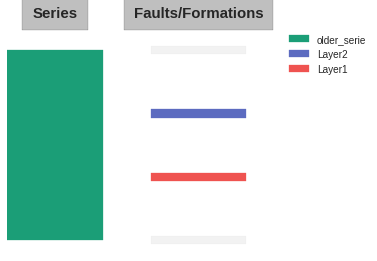

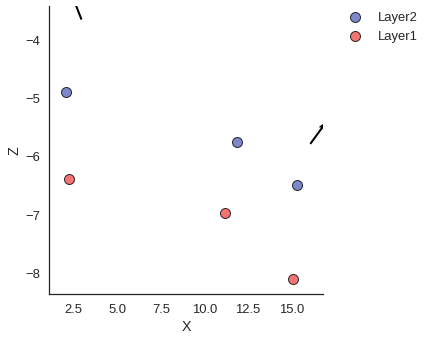

In [4]:
gp.set_series(geo_data, {'fault_serie1': 'fault1','younger_serie' : 'Unconformity', 'older_serie': ('Layer1', 'Layer2')},
              order_formations= ['fault1', 'Unconformity', 'Layer2', 'Layer1'], verbose=0)

geo_data.modify_interface(9, Z = -6.4)

geo_data = gp.select_series(geo_data, ['older_serie'])
gp.get_sequential_pile(geo_data)

gp.plot_data(geo_data)

In [5]:
interp_data = gp.InterpolatorData(geo_data, u_grade=[1], dtype='float32', verbose=[])

lith, fault = gp.compute_model(interp_data)

ver_s, sim_s = gp.get_surfaces(interp_data,lith[1], None, original_scale=True)

Compiling theano function...
Compilation Done!
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float32


### Defining functions to compute gray voxels

In [6]:
def getBinLengthAndCenter(up, down, res):
    intervals  = np.arange(1, 2*res, 2)
    divide  = (up - down)/(2*res)
    centers = down + intervals*divide
    return divide, centers
    
# function to compute centroids of voxels in our domain
# returns coordinates of centroids and half the voxel length along each coordinate axis
def computeCentroids(xdown, xup, ydown, yup, zdown, zup, res):
    # Compute intervals
    dividex, possx = getBinLengthAndCenter(xup, xdown, res)
    dividey, possy = getBinLengthAndCenter(yup, ydown, res)
    dividez, possz = getBinLengthAndCenter(zup, zdown, res)
    
    # Get all centroids by combinations of x, y, z
    cposs = [possx, possy, possz]
    centroids = list(itertools.product(*cposs))
    
    return np.array(centroids), dividex, dividey, dividez

# Computing which voxels are cutted by which simpleces
# Functions
# radius corresponds to half the diagonal of the voxel
def computeVoxelRadius( xdown,  xup,  ydown, yup, zdown,  zup,  res):
    binSize = lambda up, down: (up - down)/res
    
    bin_size_x = binSize(xup, xdown)
    bin_size_y = binSize(yup, ydown)
    bin_size_z = binSize(zup, zdown)
    return np.sqrt(bin_size_x**2 + bin_size_y**2 + bin_size_z**2)/2

def dist(center, points):
    return np.sqrt( np.sum( (center - points)**2, axis=1) )

intersections = {'layer': [], 'voxel': [], 'simplex': []}

# @ students: check if this is still necessary
# calculate centroids of voxels in domain 
centroids, dividex, dividey, dividez = computeCentroids(xdown, xup, ydown, yup, zdown, zup, res)

# ++++++++++++++++
# Theano function t
import theano.tensor as T
import theano
    

x_1 = T.matrix()
x_2 = T.matrix()
radious = T.scalar()

    # T.maximum avoid negative numbers increasing stability
sqd = T.sqrt(T.maximum(
    (x_1**2).sum(1).reshape((x_1.shape[0], 1)) +
    (x_2**2).sum(1).reshape((1, x_2.shape[0])) -
    2 * x_1.dot(x_2.T), 0.000001
))

sqd_reshaped = sqd.reshape((-1, 3, sqd.shape[1]))

sqd_bool = T.lt(sqd_reshaped, radious)

check = T.prod(sqd_bool, axis=1)

indi = T.nonzero(check)

th_f = theano.function([x_1, x_2, radious], indi, allow_input_downcast=True)


# +++++++++++++++++++++
# Code to compute volume ratio in cutted voxels
# First compute plane of triangle cutting the voxel, then with plane function evaluate which points of voxel are 
# above and below, then compute with ConvexHull the volume ratio
class Plane:
    def __init__(self, three_poins):
        u = three_poins[1] - three_poins[0]
        v = three_poins[2] - three_poins[0]
        self.normal =  np.cross(u, v)
        self.const  = -np.dot(self.normal, three_poins[2])
        
    
    def evaluatePlaneEqn(self, points):
        return np.array([self.normal.dot(p) + self.const for p in points])
        
    def classify(self, points):
        """
        Decide which point is on top and which is below the plane.
        """
        residuals = self.evaluatePlaneEqn(points)
        upper     = np.where(residuals > 0.0)
        lower     = np.where(residuals < 0.0)
        return upper, lower
    

def uniqueTriNodes(tris):
    """
    Returns an array with the unique nodes in a list of triangles.
    """
    return np.array(list(set([tuple(row) for row in np.vstack(tris)])))

def getRatiosQuadTris(quad, tris):
    plane = Plane(tris[0])
    upper, lower = plane.classify(quad)
    
    tri_points = uniqueTriNodes(tris)
    upper_hull = ConvexHull(np.vstack([quad[upper], tri_points]))
    lower_hull = ConvexHull(np.vstack([quad[lower], tri_points]))
    
    upper_volume = upper_hull.volume
    lower_volume = lower_hull.volume
    total_volume = upper_volume + lower_volume
    return upper_volume/total_volume, lower_volume/total_volume


def getTriangle(layer_idx, sims_idx):
    return [ver_s[layer_idx][sim_s[layer_idx][i]] for i in sims_idx]

def getQuad(centroid, dx, dy, dz):
    
        
    # Calculate volume ratios of cutted voxels
    uni_vox_points = np.array([[-1, -1, -1], 
                               [ 1, -1, -1], 
                               [ 1,  1, -1], 
                               [-1,  1, -1], 
                               [-1, -1,  1], 
                               [ 1, -1,  1], 
                               [ 1,  1,  1], 
                               [-1,  1,  1]])
    
    return centroid + uni_vox_points*[dx, dy, dz]


### Plotting stuff

In [7]:
# # Here we can see the marching cube error and why with so little resolution does not work
# gp.plot_scalar_field(geo_data, lith[1], 2)
# ax = plt.gca()
# ax.set_xticks(np.linspace(0, 20, res, endpoint=False))
# ax.set_yticks(np.linspace(-10, 10, res, endpoint=False))
# plt.grid()

In [8]:
# # Plot centroids of the voxels as well as the corner points of the simplices of the different layers 
# fig = plt.figure()
# ax = Axes3D(fig)
# ax.scatter3D(*centroids.T, s=40, color='b', alpha=0.05)
# ax.scatter3D(*geo_data.grid.values.T, color='y', alpha=0.05)  # Now they are the same!
# ax.scatter3D(*ver_s[0].T,  s=40, color='g', alpha=1.0)
# ax.scatter3D(*ver_s[1].T,  s=40, color='r', alpha=1.0)
# ax.set_xlim(xdown, xup)
# ax.set_ylim(ydown, yup)
# ax.set_zlim(zdown, zup)

### Code to compute the gray voxels

In [9]:
def compute_gray_voxels():
    # Running the loop with the theano function

    # The number of triangles to choose at every iteration. If you run out of memory
    # use a smaller number
    size_chunk_max = 200



    # Computing the maximum radio. The error selecting multiple voxel comes
    # because the voxels are not cubes I think
    radious = computeVoxelRadius(xdown, xup, ydown, yup, zdown, zup, res)



    # Looping the layers
    for clayer, (sim_l, ver_l) in enumerate(zip(sim_s, ver_s)): # all the layers
        # Inint the slicing of triangles
        n_triangles_0 = 0

        # Selecting the size of the chunk of triangles
        if sim_l.shape[0]+1 < size_chunk_max:
            size_chunk = sim_l.shape[0]
        else:
            size_chunk = size_chunk_max 

        # Looping chunks of triangles
        for n_triangles_1 in np.linspace(size_chunk, sim_l.shape[0],( sim_l.shape[0]+1)/size_chunk, dtype=int):      

            # selecting chunk 
            ver_t = ver_l[sim_l][n_triangles_0:n_triangles_1]

            # Computing indices
            indices= th_f(ver_t.reshape(-1, 3), centroids, radious)

            # Storing results
            if n_triangles_0 is 0 and clayer is 0:
                layers = clayer*np.ones(indices[0].shape[0])
                voxels = indices[1]
                simpleces = indices[0]+n_triangles_0
            else:
                layers = np.hstack((layers, clayer*np.ones(indices[0].shape[0])))
                voxels = np.hstack((voxels, indices[1]))
                simpleces = np.hstack((simpleces,indices[0]+n_triangles_0))

            # Switching the slice interval
            n_triangles_0 = n_triangles_1
            
    # Passing the results to same format as it was before
    intersections = {'layer': [], 'voxel': [], 'simplex': []}


    intersections['voxel'] = voxels.astype(int)
    intersections['simplex'] = simpleces.astype(int)
    intersections['layer'] = layers.astype(int)



    n_interfaces  = len(np.unique(intersections['layer']))
    unique_voxels = np.unique(intersections['voxel'])

    voxel_ratio = np.zeros((len(unique_voxels), n_interfaces + 1))
    voxels = []
    
    for i, vox in enumerate(unique_voxels):
        voxels.append(vox)

        # Gather data
        indices = intersections['voxel'] == vox
        cutting_sims   = intersections['simplex'][indices]
        cutting_layers = intersections['layer'][indices]

        # Reconstruct the voxel (gives corner points of voxel)
        quad = getQuad(centroids[vox], dividex, dividey, dividez)

        unique_cutting_layers = np.unique(cutting_layers)

        # I am sorry for the confusing naming of variables. In the following we consider two cases. The voxel is only
        # cutted by one layer and the voxel is cutted by two layers. But actually those layers are interfaces between 
        # layers. So in the first case one interface is dividing the voxel in two layers. Upper_ratio gives the volume 
        # ratio of the layer above the interface and lower_ratio gives the volume ratio of the layer below the interface. 
        # In the second case is a bit more complicated. Here the voxel is cutted by two interfaces into three layers.
        # First we compute for the first interface (upper interface) only the volume ratio of the layer above. Then we 
        # compute for the second interface (lower interface, called third layer here)  the volume ratio of the layer below.
        # Now we are only missing the volume ratio of the layer between the two interfaces --> mid layer. We easily computing
        # by substracting the two other ratios of one. The code can only deal so far with voxels cutted by maximum two 
        # layers (which is sufficient for our model problem). For voxels cutted by more layers it gives a value error.

        if len(unique_cutting_layers) == 1: # voxel is cutted by one layer
            cutting_layer = cutting_layers[0]
            tri = getTriangle(cutting_layer, cutting_sims)
            upper_ratio, lower_ratio = getRatiosQuadTris(quad, tri)

            voxel_ratio[i, cutting_layer]     = upper_ratio
            voxel_ratio[i, cutting_layer + 1] = lower_ratio

        elif len(unique_cutting_layers) == 2: # voxel is cutted by two layers
            unique_cutting_layers = np.sort(unique_cutting_layers)

            # 1st layer
            ## Gather data
            first_layer = unique_cutting_layers[0]
            first_sims  = cutting_sims[cutting_layers == first_layer]
            tri = getTriangle(first_layer, first_sims)

            ## Computation
            first_ratio, _ = getRatiosQuadTris(quad, tri)

            ## Store result
            voxel_ratio[i, first_layer] = first_ratio


            # 3nd layer
            ## Gather data
            third_layer = unique_cutting_layers[1]
            third_sims  = cutting_sims[cutting_layers == third_layer]
            tri = getTriangle(third_layer, third_sims)

            ## Computation
            _, third_ratio = getRatiosQuadTris(quad, tri)


            ## Store result
            voxel_ratio[i, third_layer + 1] = third_ratio


            # Mid layer
            mid_layer = third_layer
            voxel_ratio[i, mid_layer] = 1 - first_ratio - third_ratio

        else:
            raise ValueError('Cannot compute more than 2 interfaces/layers cutting a voxel')
            
    weigths_df = pn.DataFrame(voxel_ratio, index=voxels)
    return weigths_df

In [10]:
weigths_df = compute_gray_voxels()

# Initial model gravity using gray voxels

In [11]:
# Here in verbose is set density block to see that some of the voxels have the density changed
# When making this stochastic it is better to delete it to avoid many prints
interp_data_grav = gp.InterpolatorData(geo_data, u_grade=[1], dtype='float32', verbose=[], output='gravity')

In [12]:
# After compoling we need to set so
gp.set_geophysics_obj(interp_data_grav,  [0.1,19.9,.1,19.9, -20, 0], # Extent
                                             [1,1], ) # Resoluion of the measurement

In [13]:
# Now we compute the distances and the component z from the points where we want to compute gravity (in this case just 1 pixel)
# To all the voxels within a range
# This function also works to change the values of each rock type to densities
gp.precomputations_gravity(interp_data_grav, 1, [2.92, 3.1, 2.61]); 

In [14]:
# First we compile the theano function as ususal
interp_data_grav.th_fn = interp_data_grav.compile_th_fn(output='gravity')

Compiling theano function...
Compilation Done!
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float32


In [15]:
# @ students: this is only if you want to store the weigths in the hard disk
# weigths_df.to_pickle("weights.pickle")
# del weigths_df
# weigths_df = pn.read_pickle("weights.pickle")

In [16]:
# Now we need to set the indecies of voxels that are gray
interp_data_grav.interpolator.tg.weigths_index.set_value(weigths_df.index.values)

# And for those indeces the weighted density
interp_data_grav.interpolator.tg.weigths_weigths.set_value((weigths_df *  [2.92, 3.1, 2.61] ).values.sum(axis=1))

In [17]:
# This cell is in case you want to see the case of no-gray voxels for comparison
if False:
    interp_data_grav.interpolator.tg.weigths_index.set_value([])
    interp_data_grav.interpolator.tg.weigths_weigths.set_value([])

In [18]:
# Now we compute
lith, _, grav = gp.compute_model(interp_data_grav, output='gravity')

### Plotting

In [19]:
grav

array([ 13.34326363], dtype=float32)

(-2, 22)

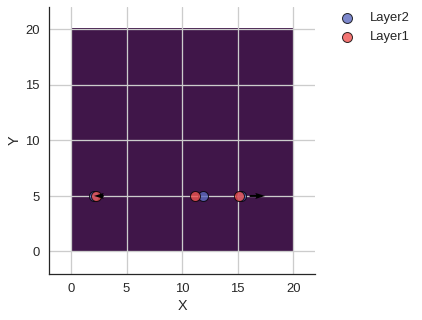

In [20]:
# Here we can plot the model and the gravity. Because we are doing just one voxel the image is not too sexy
gp.plot_section(geo_data, lith[-1], 5, direction='z',plot_data=True)

plt.grid()
fig = plt.gcf()
ax = plt.gca()
ax.imshow([grav], cmap='viridis', origin='lower', alpha=0.8, extent=[0,20,0,20])
plt.xlim(-2,22)
plt.ylim(-2,22)

## Bayesian Inference

Here we can see the uncertainty we have. Basically 2 m of std in direction Z:

In [21]:
gp.get_data(geo_data, verbosity=2)

G_x          G_y      G_z        X X_std  Y Y_std  \
interfaces   0       NaN          NaN      NaN  2.05919   NaN  5   NaN   
             1       NaN          NaN      NaN  11.8431   NaN  5   NaN   
             2       NaN          NaN      NaN  15.3178   NaN  5   NaN   
             3       NaN          NaN      NaN  2.21158   NaN  5   NaN   
             4       NaN          NaN      NaN  11.1726   NaN  5   NaN   
             5       NaN          NaN      NaN  15.1044   NaN  5   NaN   
orientations 3 -0.365657   -6.717e-17  0.93075  2.94296   NaN  5   NaN   
             2  0.588166  3.60148e-17  0.80874    16.08   NaN  5   NaN   

                      Z Z_std                       annotations azimuth  \
interfaces   0 -4.90856     2  ${\bf{x}}_{\alpha \,{\bf{1}},0}$     NaN   
             1 -5.76199     2  ${\bf{x}}_{\alpha \,{\bf{1}},1}$     NaN   
             2  -6.4935     2  ${\bf{x}}_{\alpha \,{\bf{1}},2}$     NaN   
             3     -6.4     2  ${\bf{x}}_{\alpha \,{\bf{2}},0}$     NaN   
             4 -6.98117     2  ${\bf{x}}_{\alpha \,{\bf{2}},1}$     NaN   
             5 -8.10891     2  ${\bf{x}}_{\alpha \,{\bf{2}},2}$     NaN   
orientations 3   -3.659   NaN   ${\bf{x}}_{\beta \,{\bf{1}},0}$     270   
             2   -5.792   NaN   ${\bf{x}}_{\beta \,{\bf{2}},0}$      90   

               azimuth_std     dip dip_std formation formation number isFault  \
interfaces   0         NaN     NaN     NaN    Layer2                1   False   
             1         NaN     NaN     NaN    Layer2                1   False   
             2         NaN     NaN     NaN    Layer2                1   False   
             3         NaN     NaN     NaN    Layer1                2   False   
             4         NaN     NaN     NaN    Layer1                2   False   
             5         NaN     NaN     NaN    Layer1                2   False   
orientations 3         NaN  21.448     NaN    Layer2                1   False   
             2         NaN  36.027     NaN    Layer1                2   False   

               order_series polarity       series  
interfaces   0            3      NaN  older_serie  
             1            3      NaN  older_serie  
             2            3      NaN  older_serie  
             3            3      NaN  older_serie  
             4            3      NaN  older_serie  
             5            3      NaN  older_serie  
orientations 3            3        1  older_serie  
             2            3        1  older_serie

But because we need to rescale everything before computing (this happens when we create the interp_data), the value we use in the distriburtions are... are wrong :D: FIXED!

In [22]:
gp.get_data(interp_data_grav.geo_data_res, verbosity=2)

G_x          G_y      G_z         X X_std       Y Y_std  \
interfaces   0       NaN          NaN      NaN    0.2501   NaN  0.5001   NaN   
             1       NaN          NaN      NaN  0.599009   NaN  0.5001   NaN   
             2       NaN          NaN      NaN   0.72292   NaN  0.5001   NaN   
             3       NaN          NaN      NaN  0.255535   NaN  0.5001   NaN   
             4       NaN          NaN      NaN  0.575096   NaN  0.5001   NaN   
             5       NaN          NaN      NaN  0.715312   NaN  0.5001   NaN   
orientations 3 -0.365657   -6.717e-17  0.93075  0.281616   NaN  0.5001   NaN   
             2  0.588166  3.60148e-17  0.80874    0.7501   NaN  0.5001   NaN   

                       Z      Z_std                       annotations azimuth  \
interfaces   0  0.534884  0.0713228  ${\bf{x}}_{\alpha \,{\bf{1}},0}$     NaN   
             1   0.50445  0.0713228  ${\bf{x}}_{\alpha \,{\bf{1}},1}$     NaN   
             2  0.478363  0.0713228  ${\bf{x}}_{\alpha \,{\bf{1}},2}$     NaN   
             3  0.481697  0.0713228  ${\bf{x}}_{\alpha \,{\bf{2}},0}$     NaN   
             4  0.460972  0.0713228  ${\bf{x}}_{\alpha \,{\bf{2}},1}$     NaN   
             5  0.420755  0.0713228  ${\bf{x}}_{\alpha \,{\bf{2}},2}$     NaN   
orientations 3  0.579445        NaN   ${\bf{x}}_{\beta \,{\bf{1}},0}$     270   
             2  0.503379        NaN   ${\bf{x}}_{\beta \,{\bf{2}},0}$      90   

               azimuth_std     dip dip_std formation formation number isFault  \
interfaces   0         NaN     NaN     NaN    Layer2                1   False   
             1         NaN     NaN     NaN    Layer2                1   False   
             2         NaN     NaN     NaN    Layer2                1   False   
             3         NaN     NaN     NaN    Layer1                2   False   
             4         NaN     NaN     NaN    Layer1                2   False   
             5         NaN     NaN     NaN    Layer1                2   False   
orientations 3         NaN  21.448     NaN    Layer2                1   False   
             2         NaN  36.027     NaN    Layer1                2   False   

               order_series polarity       series  
interfaces   0            3      NaN  older_serie  
             1            3      NaN  older_serie  
             2            3      NaN  older_serie  
             3            3      NaN  older_serie  
             4            3      NaN  older_serie  
             5            3      NaN  older_serie  
orientations 3            3        1  older_serie  
             2            3        1  older_serie

In [23]:
import pymc
interface_Z_stoch = []
foliations_dip_stoch = []
foliations_azimuth_stoch = []


# loop over the unique group id's and create a pymc.Normal distribution for each
for ind, i in interp_data_grav.geo_data_res.interfaces.iterrows():
    stoch = pymc.Normal(i['formation']+str(ind)+'_stoch', i['Z'], 1./i['Z_std']**2)
    interface_Z_stoch.append(stoch)

In [24]:
import copy
# First we extract from our original intep_data object the numerical data that is necessary for the interpolation.
# geo_data_stoch is a pandas Dataframe

# This is the inital model so it has to be outside the stochastic frame
geo_data_stoch_init = copy.deepcopy(interp_data_grav.geo_data_res)

In [25]:
gp.get_data(geo_data_stoch_init, numeric=True)

G_x           G_y      G_z         X       Y         Z  \
interfaces   0       NaN           NaN      NaN  0.250100  0.5001  0.534884   
             1       NaN           NaN      NaN  0.599009  0.5001  0.504450   
             2       NaN           NaN      NaN  0.722920  0.5001  0.478363   
             3       NaN           NaN      NaN  0.255535  0.5001  0.481697   
             4       NaN           NaN      NaN  0.575096  0.5001  0.460972   
             5       NaN           NaN      NaN  0.715312  0.5001  0.420755   
orientations 3 -0.365657 -6.717004e-17  0.93075  0.281616  0.5001  0.579445   
             2  0.588166  3.601481e-17  0.80874  0.750100  0.5001  0.503379   

                azimuth     dip  polarity  
interfaces   0      NaN     NaN       NaN  
             1      NaN     NaN       NaN  
             2      NaN     NaN       NaN  
             3      NaN     NaN       NaN  
             4      NaN     NaN       NaN  
             5      NaN     NaN       NaN  
orientations 3    270.0  21.448       1.0  
             2     90.0  36.027       1.0

In [32]:
# Insert stochastic parameters to the input data. This are the prior we have to store

@pymc.deterministic(trace=True)
def input_data(value = 0, 
               interface_Z_modifier = interface_Z_stoch,
               geo_data_stoch_init = geo_data_stoch_init,
         
               verbose=0):
    # First we extract from our original intep_data object the numerical data that is necessary for the interpolation.
    # geo_data_stoch is a pandas Dataframe
    geo_data_stoch = gp.get_data(geo_data_stoch_init, numeric=True)

    geo_data_stoch.xs('interfaces')['Z'] = np.array(interface_Z_modifier)
  
    if verbose > 0:
        print(geo_data_stoch)
        
    # then return the input data to be input into the modeling function. Due to the way pymc2 stores the traces
    # We need to save the data as numpy arrays
    return [geo_data_stoch.xs('interfaces')[["X", "Y", "Z"]].values, geo_data_stoch.xs('orientations').values]

In [108]:
# Computing the model and the gravity

@pymc.deterministic(trace=False)
def gempy_model(value=0,
                input_data=input_data, verbose=False):

    # modify input data values accordingly
    interp_data_grav.geo_data_res.interfaces[["X", "Y", "Z"]] = input_data[0]

    # Gx, Gy, Gz are just used for visualization. The theano function gets azimuth dip and polarity!!!
    interp_data_grav.geo_data_res.orientations[["G_x", "G_y", "G_z", "X", "Y", "Z", 'azimuth', 'dip', 'polarity']] = input_data[1]
    
    # you code here:
    
############################################################################################################

########################################################

# Running the loop with the theano function

# The number of triangles to choose at every iteration. If you run out of memory
# use a smaller number
size_chunk_max = 1000



# Computing the maximum radio. The error selecting multiple voxel comes
# because the voxels are not cubes I think
radious = computeVoxelRadius(xdown, xup, ydown, yup, zdown, zup, res)



# Looping the layers
for clayer, (sim_l, ver_l) in enumerate(zip(sim_s, ver_s)): # all the layers
    # Inint the slicing of triangles
    n_triangles_0 = 0
    
    # Selecting the size of the chunk of triangles
    if sim_l.shape[0]+1 < size_chunk_max:
        size_chunk = sim_l.shape[0]
    else:
        size_chunk = size_chunk_max 
    
    # Looping chunks of triangles
    for n_triangles_1 in np.linspace(size_chunk, sim_l.shape[0],( sim_l.shape[0]+1)/size_chunk, dtype=int):      
        
        # selecting chunk 
        ver_t = ver_l[sim_l][n_triangles_0:n_triangles_1]
        
        # Computing indices
        indices= th_f(ver_t.reshape(-1, 3), centroids, radious)
        
        # Storing results
        if n_triangles_0 is 0 and clayer is 0:
            layers = clayer*np.ones(indices[0].shape[0])
            voxels = indices[1]
            simpleces = indices[0]+n_triangles_0
        else:
            layers = np.hstack((layers, clayer*np.ones(indices[0].shape[0])))
            voxels = np.hstack((voxels, indices[1]))
            simpleces = np.hstack((simpleces,indices[0]+n_triangles_0))

        # Switching the slice interval
        n_triangles_0 = n_triangles_1
        
##########

# Passing the results to same format as it was before
intersections = {'layer': [], 'voxel': [], 'simplex': []}


intersections['voxel'] = voxels.astype(int)
intersections['simplex'] = simpleces.astype(int)
intersections['layer'] = layers.astype(int)
    
########################################################

# Calculate volume ratios of cutted voxels
uni_vox_points = np.array([[-1, -1, -1], 
                           [ 1, -1, -1], 
                           [ 1,  1, -1], 
                           [-1,  1, -1], 
                           [-1, -1,  1], 
                           [ 1, -1,  1], 
                           [ 1,  1,  1], 
                           [-1,  1,  1]])

def getTriangle(layer_idx, sims_idx):
    return [ver_s[layer_idx][sim_s[layer_idx][i]] for i in sims_idx]

def getQuad(centroid, dx, dy, dz):
    return centroid + uni_vox_points*[dx, dy, dz]

n_interfaces  = len(np.unique(intersections['layer']))
unique_voxels = np.unique(intersections['voxel'])

voxel_ratio = np.zeros((len(unique_voxels), n_interfaces + 1))
voxels = []

##########

for i, vox in enumerate(unique_voxels):
    voxels.append(vox)
    
    # Gather data
    indices = intersections['voxel'] == vox
    cutting_sims   = intersections['simplex'][indices]
    cutting_layers = intersections['layer'][indices]

    # Reconstruct the voxel (gives corner points of voxel)
    quad = getQuad(centroids[vox], dividex, dividey, dividez)

    unique_cutting_layers = np.unique(cutting_layers)
    
    # I am sorry for the confusing naming of variables. In the following we consider two cases. The voxel is only
    # cutted by one layer and the voxel is cutted by two layers. But actually those layers are interfaces between 
    # layers. So in the first case one interface is dividing the voxel in two layers. Upper_ratio gives the volume 
    # ratio of the layer above the interface and lower_ratio gives the volume ratio of the layer below the interface. 
    # In the second case is a bit more complicated. Here the voxel is cutted by two interfaces into three layers.
    # First we compute for the first interface (upper interface) only the volume ratio of the layer above. Then we 
    # compute for the second interface (lower interface, called third layer here)  the volume ratio of the layer below.
    # Now we are only missing the volume ratio of the layer between the two interfaces --> mid layer. We easily computing
    # by substracting the two other ratios of one. The code can only deal so far with voxels cutted by maximum two 
    # layers (which is sufficient for our model problem). For voxels cutted by more layers it gives a value error.
    
    if len(unique_cutting_layers) == 1: # voxel is cutted by one layer
        cutting_layer = cutting_layers[0]
        tri = getTriangle(cutting_layer, cutting_sims)
        upper_ratio, lower_ratio = getRatiosQuadTris(quad, tri)

        voxel_ratio[i, cutting_layer]     = upper_ratio
        voxel_ratio[i, cutting_layer + 1] = lower_ratio
        
    elif len(unique_cutting_layers) == 2: # voxel is cutted by two layers
        unique_cutting_layers = np.sort(unique_cutting_layers)
        
        # 1st layer
        ## Gather data
        first_layer = unique_cutting_layers[0]
        first_sims  = cutting_sims[cutting_layers == first_layer]
        tri = getTriangle(first_layer, first_sims)

        ## Computation
        first_ratio, _ = getRatiosQuadTris(quad, tri)
        
        ## Store result
        voxel_ratio[i, first_layer] = first_ratio


        # 3nd layer
        ## Gather data
        third_layer = unique_cutting_layers[1]
        third_sims  = cutting_sims[cutting_layers == third_layer]
        tri = getTriangle(third_layer, third_sims)

        ## Computation
        _, third_ratio = getRatiosQuadTris(quad, tri)


        ## Store result
        voxel_ratio[i, third_layer + 1] = third_ratio


        # Mid layer
        mid_layer = third_layer
        voxel_ratio[i, mid_layer] = 1 - first_ratio - third_ratio
        
    else:
        raise ValueError('Cannot compute more than 2 interfaces/layers cutting a voxel')
        
###########

weigths_df = pn.DataFrame(voxel_ratio, index=voxels)
    
    
############################################################################################################ 

# from weighted_g

# In[19]:


# Here in verbose is set density block to see that some of the voxels have the density changed
# When making this stochastic it is better to delete it to avoid many prints
interp_data_grav = gp.InterpolatorData(geo_data, u_grade=[1], dtype='float32', verbose=['density_block'], output='gravity')


# In[20]:


# After compoling we need to set so
gp.set_geophysics_obj(interp_data_grav,  [0.1,19.9,.1,.9, -10, 0], # Extent
                                             [1,1], ) # Resoluion of the measurement


# In[21]:


# Now we compute the distances and the component z from the points where we want to compute gravity (in this case just 1 pixel)
# To all the voxels within a range
# This function also works to change the values of each rock type to densities
gp.precomputations_gravity(interp_data_grav, 1, [2.92, 3.1, 2.61]); 


# In[22]:


# First we compile the theano function as ususal
interp_data_grav.th_fn = interp_data_grav.compile_th_fn(output='gravity')


# In[23]:


weigths_df.to_pickle("weights.pickle")
del weigths_df
weigths_df = pn.read_pickle("weights.pickle")


# In[24]:


interp_data_grav.interpolator.tg.weigths_index.set_value(weigths_df.index.values)


# In[25]:


# Now we need to set the indecies of voxels that are gray
interp_data_grav.interpolator.tg.weigths_index.set_value(weigths_df.index.values)

# And for those indeces the weighted density
interp_data_grav.interpolator.tg.weigths_weigths.set_value((weigths_df *  [2.92, 3.1, 2.61] ).values.sum(axis=1))


# In[26]:


# This cell is in case you want to see the case of no-gray voxels for comparison

if False:
    interp_data_grav.interpolator.tg.weigths_index.set_value([])
    interp_data_grav.interpolator.tg.weigths_weigths.set_value([])


# In[27]:


# # Now we compute
# lith, _, grav = gp.compute_model(interp_data_grav, output='gravity')


############################################################################################################ 
    
    
    
    try:
        # try to compute model
#         lb, fb, grav = gp.compute_model(interp_data_grav, output='gravity')
        grav = gp.compute_model(interp_data_grav, output='gravity')
        if False:
            gp.plot_section(interp_data_grav.geo_data_res, lb[0], 19, plot_data=True)
           # gp.plot_data(interp_data_grav.geo_data_res, direction='y')

#       return lb, fb, grav // commented
        return grav



# try to compute model
        # lb, fb, grav = gp.compute_model(interp_data_grav, output='gravity') // commented
        #lb, fb = gp.compute_model(interp_data_grav)
        grav = gp.compute_model(interp_data_grav, output='gravity')
        if False:
            gp.plot_section(interp_data_grav.geo_data_res, lb[0], 19, plot_data=True)
           # gp.plot_data(interp_data_grav.geo_data_res, direction='y')

        #return lb, fb, grav
        return grav
    
    

    except np.linalg.linalg.LinAlgError as err:
        # if it fails (e.g. some input data combinations could lead to
        # a singular matrix and thus break the chain) return an empty model
        # with same dimensions (just zeros)
        if verbose:
            print("Exception occured.")
        return np.zeros_like(lith_block), np.zeros_like(fault_block), np.zeros_like(grav_block)

# We want to store the value of gravity but the models better not. The following chunck is only for that
@pymc.deterministic(trace=True)
def gravity(value=0, model=gempy_model):
    return model  #[2] removed

# This is a hack to force to compute the models
@pymc.stochastic(trace=True)
def nothing(value=0, gravity=gravity):
    return 1



Compiling theano function...
Compilation Done!
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float32


In [109]:
# gp.get_data(geo_data_stoch_init, numeric=True).xs('interfaces')

In [110]:
# db.trace('Layer13_stoch')[:]

In [111]:
# db.trace_names

In [112]:
# Choosing the parameters which play a role
np.random.seed(123456) # I think with this is enough to draw always the same priors to be able to compare several resolutions but check the results to be sure!

p_model = pymc.Model([*interface_Z_stoch, input_data, gempy_model, gravity, nothing])

In [113]:
S = pymc.MCMC(input=p_model, db="hdf5", dbname="MCMCs500r10")
#S.use_step_method(pymc.AdaptiveMetropolis, [*interface_Z_stoch, input_data, gempy_model, gravity, nothing], delay=1000)
S.db

In [114]:
# Sampling
S.sample(500,burn=50, tune_interval=100)

 [-----------------100%-----------------] 500 of 500 complete in 26.9 sec

Plotting Layer13_stoch
Plotting Layer22_stoch
Plotting Layer14_stoch
Plotting nothing
Plotting Layer20_stoch
Plotting Layer21_stoch
Plotting Layer15_stoch


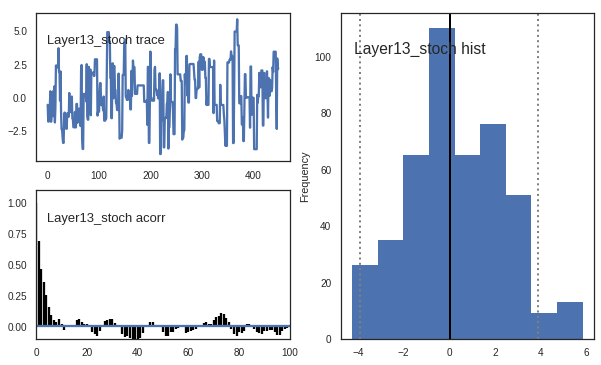

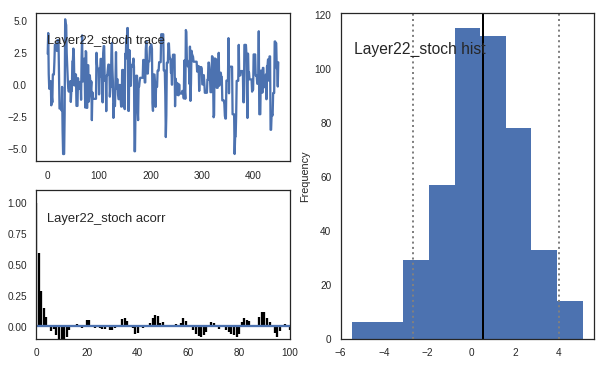

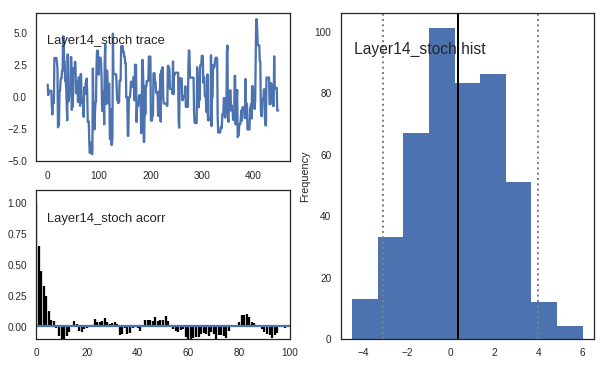

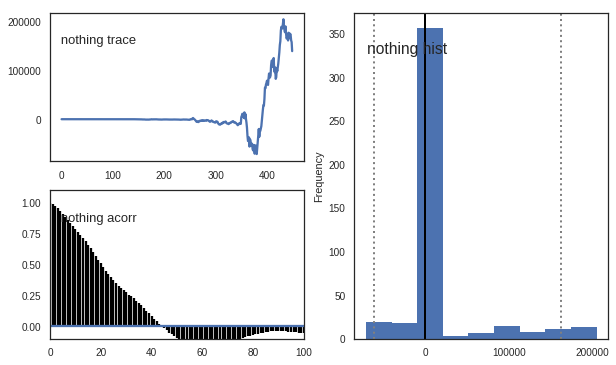

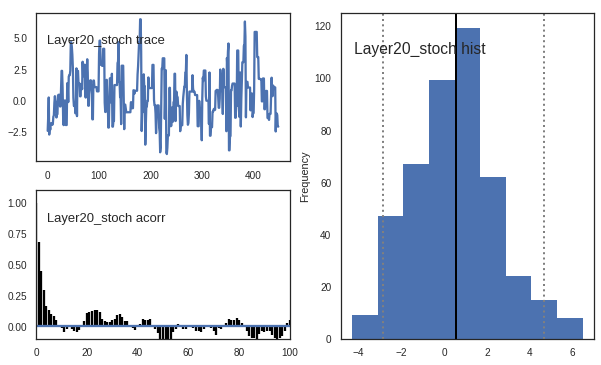

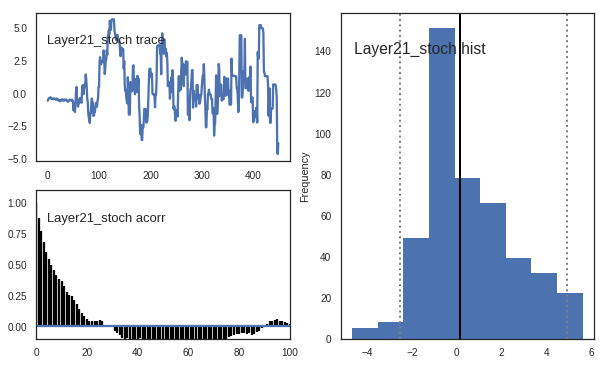

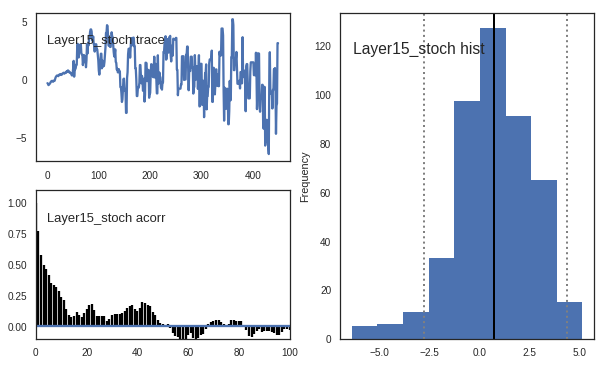

In [115]:
pymc.Matplot.plot(S)

In [116]:
# db = pymc.database.hdf5.load("MCMC_s1000_r3.hdf5")

In [117]:
# pymc.Matplot.plot(db, 'Layer22_stoch')

In [118]:
# a = db.trace('Layer22_stoch')

In [119]:
# a.stats()

In [120]:
# pymc.autocorrelation(db, maxlag=500)

In [121]:
# pymc.Matplot.autocorrelation(db, 'Layer22_stoch')

In [122]:
S.db.close()